


###  **Классификация заболеваний маниоки**
        
         В этой задаче предоставлен набор данных из 5 мелкозернистых категорий заболеваний листьев маниоки с 9436 помеченными изображениями, собранными в ходе регулярного обследования в Уганде, в основном краудсорсинговыми от фермеров, фотографируемых их садов, и аннотированных экспертами Национального научно-исследовательского института ресурсов для сельскохозяйственных культур (NaCRRI) в сотрудничестве с лабораторией искусственного интеллекта в Университете Макарере, Кампала.
       Цель состоит в том, чтобы построить модель для классификации данного изображения по этим 4 категориям заболеваний или 5-й категории, указывающей на здоровый лист.

Ссылка на датасет: https://www.kaggle.com/c/ammi-2021-convnets/data

In [2]:
## Устанавливаем путь к папкам с фотографиями для обучения и для теста
train_path = '../input/ammi-2021-convnets/train/train'
test_path = '../input/ammi-2021-convnets/test/test/0'
sample_submission_path = '../input/ammi-2021-convnets/sample_submission_file.csv'

In [3]:
## Подключаем необходимые библиотеки
!pip install efficientnet_pytorch

import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.transforms import functional as F
from torch import nn
from torchvision.models import resnet18, resnet34, resnet50, resnet152, resnet101
from efficientnet_pytorch import EfficientNet
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import os.path

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from PIL import Image
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm_notebook, tqdm

from IPython.display import clear_output
import copy
%matplotlib inline

In [4]:
## Посмотрим на то, как должен быть представлен ответ
df_result = pd.read_csv(sample_submission_path)
df_result.head()

Category              Id
0     cbsd  test-img-0.jpg
1      cmd  test-img-1.jpg
2      cbb  test-img-2.jpg
3      cmd  test-img-3.jpg
4     cbsd  test-img-4.jpg

In [5]:
## Посмотрим на распределение классов фотографий
print('cbb: {},'.format(len(os.listdir(train_path + '/cbb'))), 'cbsd: {},'.format(len(os.listdir(train_path + '/cbsd'))), 
     'cgm: {},'.format(len(os.listdir(train_path + '/cgm'))), 'cmd: {},'.format(len(os.listdir(train_path + '/cmd'))), 
     'healthy: {}'.format(len(os.listdir(train_path + '/healthy'))))

cbb: 466, cbsd: 1443, cgm: 773, cmd: 2658, healthy: 316


Видим, что классы рапределены не равномерно. Но с применением аугментации данного количества фотографий для каждого класса должно хватить для обучения

## 1. Определение необходимых функций и классов
1. Определение функций для отрисовки фотгорафий и графика обучения
2. Создание собственной имплементации нейросетей VGG и ResNet
3. Определение функций для обучения нейросетей

In [83]:
## Создадим необходимые функции 
## plot_history - функция отображает график обучения модели
## plot_images - функция для отображения 6 случайных фотографий из валидационной выборки 
## с указанием настоящей метки класса, а также предсказанной метки и уверенностью модели в ней
    
def plot_history(train_history, val_history, title):

    plt.figure(figsize = (10, 6))
    plt.title(title, fontsize=14)

    plt.plot(train_history, label='train', zorder=0, color='orange')
    
    steps = np.linspace(len(train_history)/len(val_history), len(train_history), len(val_history))
    
    plt.scatter(steps, val_history, marker='o', s=70, zorder=1, color='blue', label='val', alpha=0.7)

    plt.legend(loc='best', fontsize=12)
    plt.xlabel('train_steps', fontsize=12)
    plt.grid()

    plt.show()
    
    
def plot_images(model, valset):
    
    idx = np.random.randint(0, len(valset), size=6)
    pil_images = [valset.get_original_image(i) for i in idx]
    images = [valset[i][0] for i in idx]
    labels = [valset[i][1] for i in idx]
    labels = CassavaDataset.encoder.inverse_transform(labels)
    
    preds, preds_proba = [], []
    model.eval()
    model.to('cpu')
    for image, label in zip(images, labels):
        with torch.no_grad():
            image = image.view(1, 3, image.shape[1], image.shape[2])
            pred = model(image)
            pred_proba = nn.Softmax()(pred)
            preds.append(torch.argmax(pred_proba))
            preds_proba.append(round(float(torch.max(pred_proba)), 2))
    preds = CassavaDataset.encoder.inverse_transform(preds)
    
    fig, axes = plt.subplots(2, 3, figsize=(27,15))
    axes = axes.reshape(6,)
    fig.suptitle('Show Model Confidence', fontsize=20)
    image_loader = zip(axes, preds, preds_proba, labels, pil_images)
    
    for ax, pred, proba, label, image in image_loader:
        ax.imshow(image)
        ax.set_title('Label: {}'.format(label), fontsize=16)
        ax.text(20, 300, 'Predict: {},\n Confidence: {}'.format(pred, proba), backgroundcolor='white', fontsize=14, color='black')
    
    plt.show()
        

In [70]:
## Создадим собственную имплементацию нейросетей VGG и ResNet 

class VGGBLock(nn.Module):
    """ Класс определяющий базовый блок VGG """
    def __init__(self, in_planes, planes, maxpool_pading=0, stride=1):
        super(VGGBLock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_planes, out_channels=planes, kernel_size=3, stride=1, padding=1)
        self.norm1 =  nn.BatchNorm2d(planes)
        self.relu =  nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=planes, out_channels=planes, kernel_size=3, stride=stride, padding=1)
        self.norm2 = nn.BatchNorm2d(planes)
        self.maxpool = nn.MaxPool2d(2, padding=maxpool_pading)
        self.block = nn.Sequential(self.conv1, self.norm1, self.relu, self.conv2, self.norm2, self.relu,)
                                   
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        return out

class my_VGGNet(nn.Module):
    """ Класс собирающий базовые блоки и формирующий модель VGG"""

    def __init__(self, num_blocks, num_classes, image_size=224):
        super(my_VGGNet, self).__init__()

        blocks = [VGGBLock(3, 32)]
        i = 32
        for j in range(1, num_blocks):
            if j == 5:
                blocks.append(VGGBLock(i, int(2*i), maxpool_pading=1))
            else:
                blocks.append(VGGBLock(i, int(2*i)))
            i = int(2*i)
        self.blocks = nn.Sequential(*blocks)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Sequential(nn.Linear(in_features=16384, out_features=1024),
                                    nn.ReLU())
        
        self.out = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.blocks(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.out(x)

        return x


class BasicResidualBlock(nn.Module):
    """ Класс определяющий базовый блок нейросети ResNet"""

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1)
        self.norm = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self.downsample = downsample

    def forward(self, x):

        Inception = x

        out = self.conv1(x)
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm(out)

        if self.downsample is not None:
            Inception = self.downsample(Inception)

        out += Inception

        return self.relu(out)
        

class my_ResNet(nn.Module):
    """ Класс для опрделения модели ResNet"""

    def __init__(self, block, layers, num_classes):
        super(my_ResNet, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU()
                                   )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, 128, layers[0], 2)
        self.layer2 = self.make_layer(block, 128, 256, layers[1], 2)
        self.layer3 = self.make_layer(block, 256, 512, layers[2], 2)

        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()

        self.out = nn.Linear(in_features=4608, out_features=num_classes)


    def make_layer(self, block, in_planes, planes, num_blocks, stride):
        downsample = None
        if (stride != 1) or (in_planes != out_planes):
            downsample = nn.Sequential(nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride),
                                       nn.BatchNorm2d(planes)
                                       )
            
        layers = [block(in_planes, planes, stride, downsample)]
        in_planes = planes
        for _ in range(1, num_blocks):
            layers.append(block(in_planes, planes))
        
        return nn.Sequential(*layers)


    def forward(self, x):

        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)

        x = self.flatten(x)
        x = self.out(x)

        return x

In [63]:
## Определим функции для обучения моделей. Для измерения метрик на валлидации будем использовать
## 3 датасета с разной аугментацией. В качестве метрик будем брать среднии log_loss, accuracy,
## f1_score, а также возьмем стандартное отклонение log_loss измеренной по 3 датасетам

## fit_epoch - обучение модели для одной эпохи на обучающей выборке
## val_epoch - расчет метрик на валлидационной выборке
## train_net - полный цикл обучения модели и отоброжение графика обучения

## predict - функция для предсказания результатов на тестовой выборке
## log_predict - функция для логирования наших результатов, сюда будем записывать результаты наших моделей,
## лучших мделей для которых accuracy на валлидации превысила 90%. Данная функция удобна
## для дальнейшего сравнение 

## Для обучения будем использовать метод градиентного спуска Adam, а также логистическую функцию потерь

def fit_epoch(model, data_loader, criterion, optimizer,  device='cuda'):
    model.train()
    train_loss, train_accuracy = [], []
    train_run_loss, train_run_accuracy = [], []
    train_procesed = 0

    for images, labels in tqdm_notebook(data_loader):
        images, labels = images.to(device), labels.to(device)
        pred = model(images)
        optimizer.zero_grad()
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        _, pred_classes = torch.max(pred, 1)
        train_procesed += 1
        train_run_loss.append(loss.item())
        TP = sum((pred_classes==labels)).item()
        train_run_accuracy.append(TP/len(images))
        if train_procesed % 30 == 0:
            print(np.mean(train_run_loss))
            
    
    train_loss, train_accuracy = np.mean(train_run_loss), np.mean(train_run_accuracy)

    return train_loss, train_accuracy, train_run_loss, train_run_accuracy

def val_epoch(model, data_loaders, criterion, device='cuda'):

    model.eval()
    with torch.no_grad():
        mean_loss, mean_accuracy, mean_f1 = [], [], []
        for data_loader in data_loaders:
            val_loss, val_accuracy = [], []
            val_run_loss, val_run_accuracy, val_proccesed = 0, 0, 0
            y_pred, y_true = [], []

            for images, labels in tqdm(data_loader):
                images, labels = images.to(device), labels.to(device)
                pred = model(images)
                loss = criterion(pred, labels)
                _, pred_classes = torch.max(pred, 1)
                val_run_loss += loss.item()
                val_proccesed += 1
                y_pred.extend(pred_classes.to('cpu'))
                y_true.extend(labels.to('cpu'))


            val_loss = val_run_loss/val_proccesed
        
            y_pred, y_true = torch.FloatTensor(y_pred).numpy(), torch.FloatTensor(y_true).numpy()
            f1 = f1_score(y_true, y_pred, average='macro')
            acc = accuracy_score(y_true, y_pred)
            mean_loss.append(val_loss)
            mean_accuracy.append(acc)
            mean_f1.append(f1)

        return np.mean(mean_loss), np.mean(mean_accuracy), np.mean(mean_f1), np.std(mean_loss)


def train_net(model, trainset, valsets, batch_size, num_epoch, learning_rate=1e-4):

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    val_loaders = [DataLoader(valset, batch_size=batch_size, shuffle=False) for valset in valsets]
    log_preds = []

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion= nn.CrossEntropyLoss()
    
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    model.to(device)
    
    train_loss_run_history, train_accuracy_run_history = [], []
    train_loss_history, train_accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []
    f1_list = []
    val_variance = []
    for epoch in range(num_epoch):

        train_loss, train_accuracy, train_run_loss, train_run_accuracy = fit_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, f1, variance = val_epoch(model, val_loaders, criterion, device)
        train_loss_run_history.extend(train_run_loss)
        train_accuracy_run_history.extend(train_run_accuracy)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        val_variance.append(variance)

        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)
        f1_list.append(f1)

        clear_output()
        plot_history(train_loss_run_history, val_loss_history, title='Loss')
        plot_history(train_accuracy_run_history, val_accuracy_history, title='Accuracy')

        if epoch == 0:
            print('Iteration: {}'.format(epoch))
            print('Train_loss: {}'.format(train_loss_history[epoch]))
            print('Train_accuracy: {}'.format(train_accuracy_history[epoch]))
            print('Val_loss: {}'.format(val_loss_history[epoch]))
            print('Val_accuracy: {}'.format(val_accuracy_history[epoch]))
            print('F1_score: {}'.format(f1_list[epoch]))
            print('Val_variance_loss: {}'.format(val_variance[epoch]))
        elif epoch == 1:
            print('Iteration: {}'.format(epoch))
            print('Train_loss: {}, {}'.format(train_loss_history[epoch-1], train_loss_history[epoch]))
            print('Train_accuracy: {}, {}'.format(train_accuracy_history[epoch-1], 
                                                  train_accuracy_history[epoch]))
            
            print('Val_loss: {}, {}'.format(val_loss_history[epoch-1], val_loss_history[epoch]))
            print('Val_accuracy: {}, {}'.format(val_accuracy_history[epoch-1], val_accuracy_history[epoch]))
            print('F1_score: {}, {}'.format(f1_list[epoch-1], f1_list[epoch]))
            print('Val_variance_loss: {}, {}'.format(val_variance[epoch-1], val_variance[epoch])) 
        else:
            print('Iteration: {}'.format(epoch))
            print('Train_loss: {}, {}, {}'.format(train_loss_history[epoch-2], train_loss_history[epoch-1], 
                                                  train_loss_history[epoch]))
            
            print('Train_accuracy: {}, {}, {}'.format(train_accuracy_history[epoch-2],
                                                      train_accuracy_history[epoch-1], 
                                                      train_accuracy_history[epoch]))
            
            print('Val_loss: {}, {}, {}'.format(val_loss_history[epoch-2], val_loss_history[epoch-1], 
                                                val_loss_history[epoch]))
            
            print('Val_accuracy: {}, {}, {}'.format(val_accuracy_history[epoch-2],
                                                    val_accuracy_history[epoch-1], 
                                                    val_accuracy_history[epoch]))
            
            print('F1_score: {}, {}, {}'.format(f1_list[epoch-2], f1_list[epoch-1], f1_list[epoch]))
            print('Val_variance_loss: {}, {}, {}'.format(val_variance[epoch-2], val_variance[epoch-1], 
                                                         val_variance[epoch]))
            
        if val_accuracy >= 0.9:
            log_preds.append(log_predict(model, epoch, testset_3, (val_loss, val_accuracy), 
                                         (train_loss, train_accuracy), variance))

    return log_preds


def predict(model, testset, batch_size=128):

    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    

    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    model.to(device)
    result, result_path = [], []
    logits = torch.zeros(len(testset), 5)
    i = 0
    model.eval()
    for images, path in tqdm(test_loader):
        images = images.to(device)
        with torch.no_grad():
            pred = model(images)
            logits[i:i + len(images)] = pred.to('cpu')
            i += len(images)
            _, pred_classes = torch.max(pred, 1)
            result.extend(pred_classes.to('cpu'))
            result_path.extend(path)
            
    
    logits = logits.numpy()
    result = torch.FloatTensor(result).numpy().astype('int')
    result = CassavaDataset.encoder.inverse_transform(result)
    
    return result, result_path, logits
    


def log_predict(model, epoch, testset, val_score, train_score, val_variance):
    pred, path, logits = predict(model, testset, batch_size=16)
    new_model = copy.deepcopy(model)
    result = {'Epoch': {'epoch': epoch, 'model': new_model} , 'val_loss': val_score[0], 
              'val_accuracy': val_score[1], 'train_loss': train_score[0],
              'train_accuracy': train_score[1], 'val_variance': val_variance, 
              'answers': {'Category': pred, 'Id': path, 'logits': logits}}
    return result

## 2. Предподготовка данных
1. Создание датасета с фотографиями листьев маниоки
2. Применение аугментации данных

In [66]:
## Создаем датасет с фотографиями
class CassavaDataset(Dataset):
    """ Класс для формирования датасета, который будет итерироваться по адрессам фотографий в папках обучения,
    валлидации и теста"""
    
    encoder = LabelEncoder()

    def __init__(self, path, transform=None, type_sample='train', val_size=0.33, random_state=42):

        self.transform = transform
        self.type_sample = type_sample
        self.random_state = random_state

        ## Определяем функцию, котрая создает два списка. 
        ## Первый с адресами фотографий, второй с метками соответствующих классов.
        ## Также функция должна возвращать индексы для разделения данных на обучение и валлидацию,
        ## учитывая каждый класс отдельно
        def ImageLoader(path, labels=None, encode_labels=None, val_size=val_size):
            data_data, data_labels, = [], []
            val_idx_list, train_idx_list =[], []
            start, end = 0, 0
            if labels is not None:
                
                if self.random_state is None:
                    self.random_state=0
                
                for label, encode_label in zip(labels, encode_labels):
            
                    images = [os.path.join(path, label, x) for x in os.listdir(os.path.join(path, label))] 
                    data_data.extend(images)
                    data_labels.extend([encode_label for _ in range(len(images))])
                    
                    end += len(images)
                    val_idx = np.random.choice(list(range(start, end)), size=int(val_size*len(images)), replace=False)
                    val_idx = list(set(val_idx))
                    train_idx = list(set(range(start, end)) - set(val_idx))
                    val_idx_list.extend(val_idx)
                    train_idx_list.extend(train_idx)
                    start = end

                return np.array(data_data), np.array(data_labels), train_idx_list, val_idx_list

            else:
                data_data = [os.path.join(path, x) for x in sorted(os.listdir(path))]

                return data_data, sorted(os.listdir(path))

        ## Закодируем метки классов с помощью LabelEncoder, 
        ## также проверим парвильность разделения данных на обучение и валлидацию
        if type_sample in ['train', 'val']:
            labels = np.array(os.listdir(path))
            encode_labels = CassavaDataset.encoder.fit_transform(labels)

            self.images, self.labels, train_idx, val_idx = ImageLoader(path, labels, encode_labels)
                                
            assert len(self.images) == len(self.labels) 
            assert sorted(list(set(self.images[train_idx]).union(self.images[val_idx]))) == sorted(self.images)
            assert (len(self.images[train_idx])+len(self.images[val_idx])) == len(self.images)

            if type_sample == 'train':
                self.images, self.labels= self.images[train_idx], self.labels[train_idx]
            else:
                self.images, self.labels = self.images[val_idx], self.labels[val_idx]

        elif type_sample == 'test':
            self.images, self.images_path = ImageLoader(path)     
        
        else:
            raise NameError
            
    
    def __len__(self):
          return len(self.images)
    
    ## В функции __getitem__ применим необходимую трансформацию данных, 
    ## также сразу выполним нормализацию, используя BatchNorm
    def __getitem__(self, idx):

        x = Image.open(self.images[idx])
        if self.transform is not None:
            x = self.transform(x)
            x = nn.BatchNorm2d(3)(x.view(1, 3, x.shape[1], x.shape[2]))
            x = x.view(3, x.shape[2], x.shape[3])
        if self.type_sample != 'test':    
            y = self.labels[idx]
            return x, y
        else:
            return x, self.images_path[idx]


        
    def get_original_image(self, idx):  ## Добавим еще один метод для отображение оригинальной фотографии
        x = Image.open(self.images[idx])
        return x
    

In [ ]:
## Тперь создадим еще две дополнительные функции для аугментации наших фотографий
## val_tranform_1 - разворачивает изорбражение по горизонтали и добавляет размытие
## val_transform_2 - разворачивает изорбражение по вертикали и добавляет насыщенность
def val_tranform_1(image):
    x = transforms.Resize(size=(448, 448))(image)
    x = transforms.ToTensor()(x)
    x = F.hflip(x)
    x = transforms.GaussianBlur(3)(x)
    return x

def val_transform_2(image):
    x = transforms.Resize(size=(448, 448))(image)
    x = transforms.ToTensor()(x)
    x = F.vflip(x)
    x  = F.adjust_saturation(x, 1.4)
    return x

In [67]:
## Определим разные виды трансформации данных
## transform_1 - преобразование к размеру (224х224) без аугментации
## transform_2 - преобразование к размеру (224х224) с аугментацией
## transform_3, 3_1, 3_2, 3_3 - преобразование к размеру (448х448) с аугментацией

transform_1 = transforms.Compose([transforms.Resize(size=(224, 224)),
                                  transforms.ToTensor()])


transform_2 = transforms.Compose([transforms.Resize(size=(256, 256)),
                                  transforms.ToTensor(),
                                  transforms.RandomHorizontalFlip(0.5),
                                  transforms.RandomVerticalFlip(0.5),
                                  transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.6),
                                                          transforms.GaussianBlur(7)], 0.5),
                                  transforms.RandomRotation(15),
                                  transforms.RandomErasing(scale=(0.05, 0.05)),
                                  transforms.RandomCrop(size=(224,224)),
                                  ])

transform_3 = transforms.Compose([transforms.Resize(size=(480, 480)),
                                  transforms.ToTensor(),
                                  transforms.RandomHorizontalFlip(0.5),
                                  transforms.RandomVerticalFlip(0.5),
                                  transforms.RandomApply([transforms.ColorJitter(0.8, 0.5, 0.6),
                                                          transforms.GaussianBlur(3)], 0.5),
                                  transforms.RandomRotation(15),
                                  transforms.RandomErasing(scale=(0.05, 0.05)),
                                  transforms.RandomCrop(size=(448,448)),
                                 ])
transform_3_1 = transforms.Compose([transforms.Resize(size=(448, 448)),
                                  transforms.ToTensor()])
transform_3_2 = val_tranform_1
transform_3_3 = val_transform_2


## Датасеты для фотографий размера (224х224)
trainset_1 = CassavaDataset(path=train_path, transform=transform_1, type_sample='train', 
                            val_size=0.1, random_state=777) ## без аугментации

trainset_2 = CassavaDataset(path=train_path, transform=transform_2, type_sample='train',
                            val_size=0.1, random_state=777) ## с аугментацией

valset_1 = CassavaDataset(path=train_path, transform=transform_1, type_sample='val', 
                          val_size=0.1, random_state=777)

testset_1 = CassavaDataset(path=test_path, transform=transform_1, type_sample='test')

## Датасеты для фотографий размера (448х448) с аугментацией
## Здесь создадим 3 валлидационных датасета, с разной агментацией, тем самым увеличим нашу валлидационную выборку втрое
trainset_3 = CassavaDataset(path=train_path, transform=transform_3, type_sample='train',
                            val_size=0.1, random_state=777) ## с аугментацией

valset_3_1 = CassavaDataset(path=train_path, transform=transform_3_1, type_sample='val',
                            val_size=0.1, random_state=777)

valset_3_2 = CassavaDataset(path=train_path, transform=transform_3_2, type_sample='val',
                            val_size=0.1, random_state=777)

valset_3_3 = CassavaDataset(path=train_path, transform=transform_3_3, type_sample='val',
                            val_size=0.1, random_state=777)

testset_3 = CassavaDataset(path=test_path, transform=transform_3_1, type_sample='test')

## 3. Обучение моделей
1. Обучение собственных моделей
2. Обучение моделей, предобученных на ImageNet

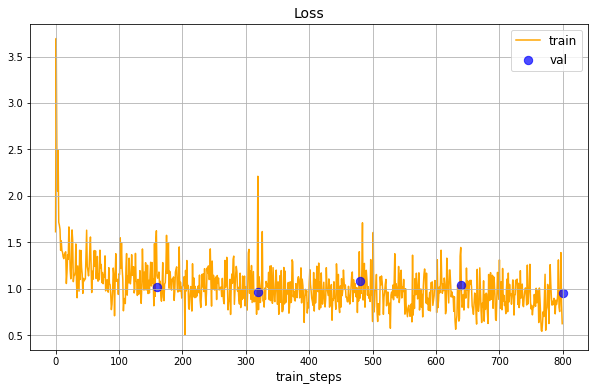

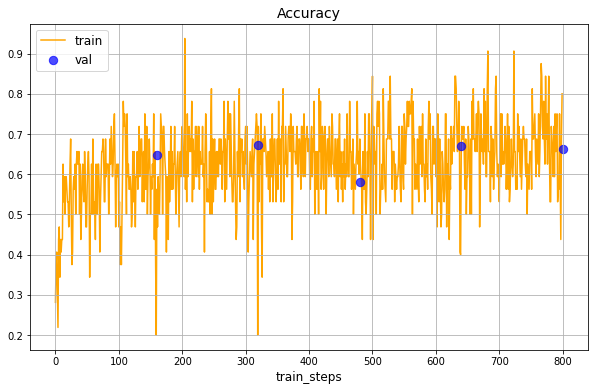

Iteration: 4
Train_loss: 0.974788150191307, 0.9575473465025425, 0.9084454040974379
Train_accuracy: 0.6418359375, 0.64546875, 0.6653515624999999
Val_loss: 1.0847946107387543, 1.0368269268009398, 0.9530080722437965
Val_accuracy: 0.5808170515097691, 0.6696269982238011, 0.6625222024866785
F1_score: 0.41882790755855764, 0.4088176307386545, 0.5228949366558634
Val_variance_loss: 0.0, 0.0, 0.0


In [47]:
## Попробуем обучить собственную модель VGGNet из 6 базовых блоков с нуля на 5 эпохах , без аугментации
my_vgg = my_VGGNet(num_blocks=6, num_classes=5)
log_preds = train_net(my_vgg, trainset_1, [valset_1], batch_size=32, num_epoch=5) 
                                                                                                        

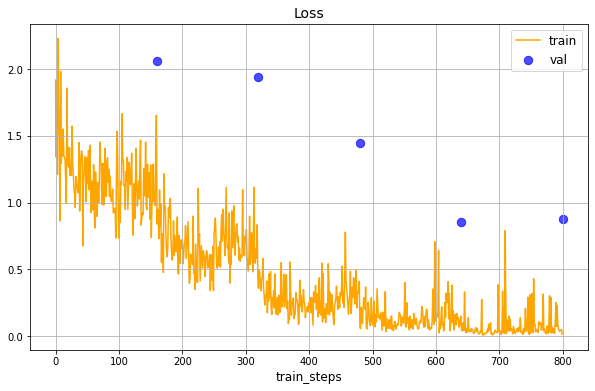

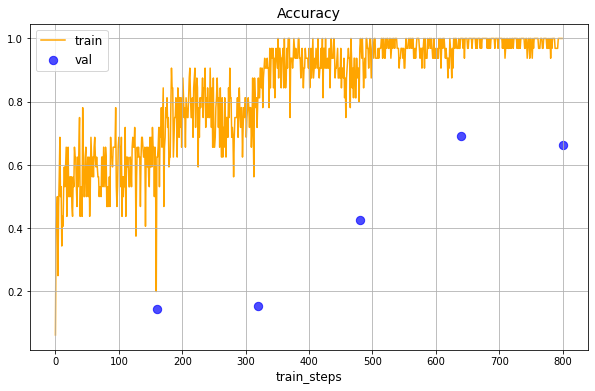

Iteration: 4
Train_loss: 0.2853885598946363, 0.14159513962222264, 0.07793491973425262
Train_accuracy: 0.9149609375000001, 0.9650390625, 0.9884765625
Val_loss: 1.4447374045848846, 0.8557531767421298, 0.881216511130333
Val_accuracy: 0.42451154529307283, 0.6909413854351687, 0.6642984014209592
F1_score: 0.34546712614491326, 0.5501550149568073, 0.5782839790656872
Val_variance_loss: 0.0, 0.0, 0.0


In [48]:
## Попробуем обучить собственную модель ResNet из 4 слоев по 2 блока в каждом с нуля на 5 эпохах, 
## без аугментации
my_resnet = my_ResNet(BasicResidualBlock, [2, 2, 2, 2], num_classes=5)
log_preds = train_net(my_resnet, trainset_1, [valset_1], batch_size=32, num_epoch=5)
                                                                                                     

Собственные модели отработали премерно одинаково и видим, что качество растет не слишком хорошо

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


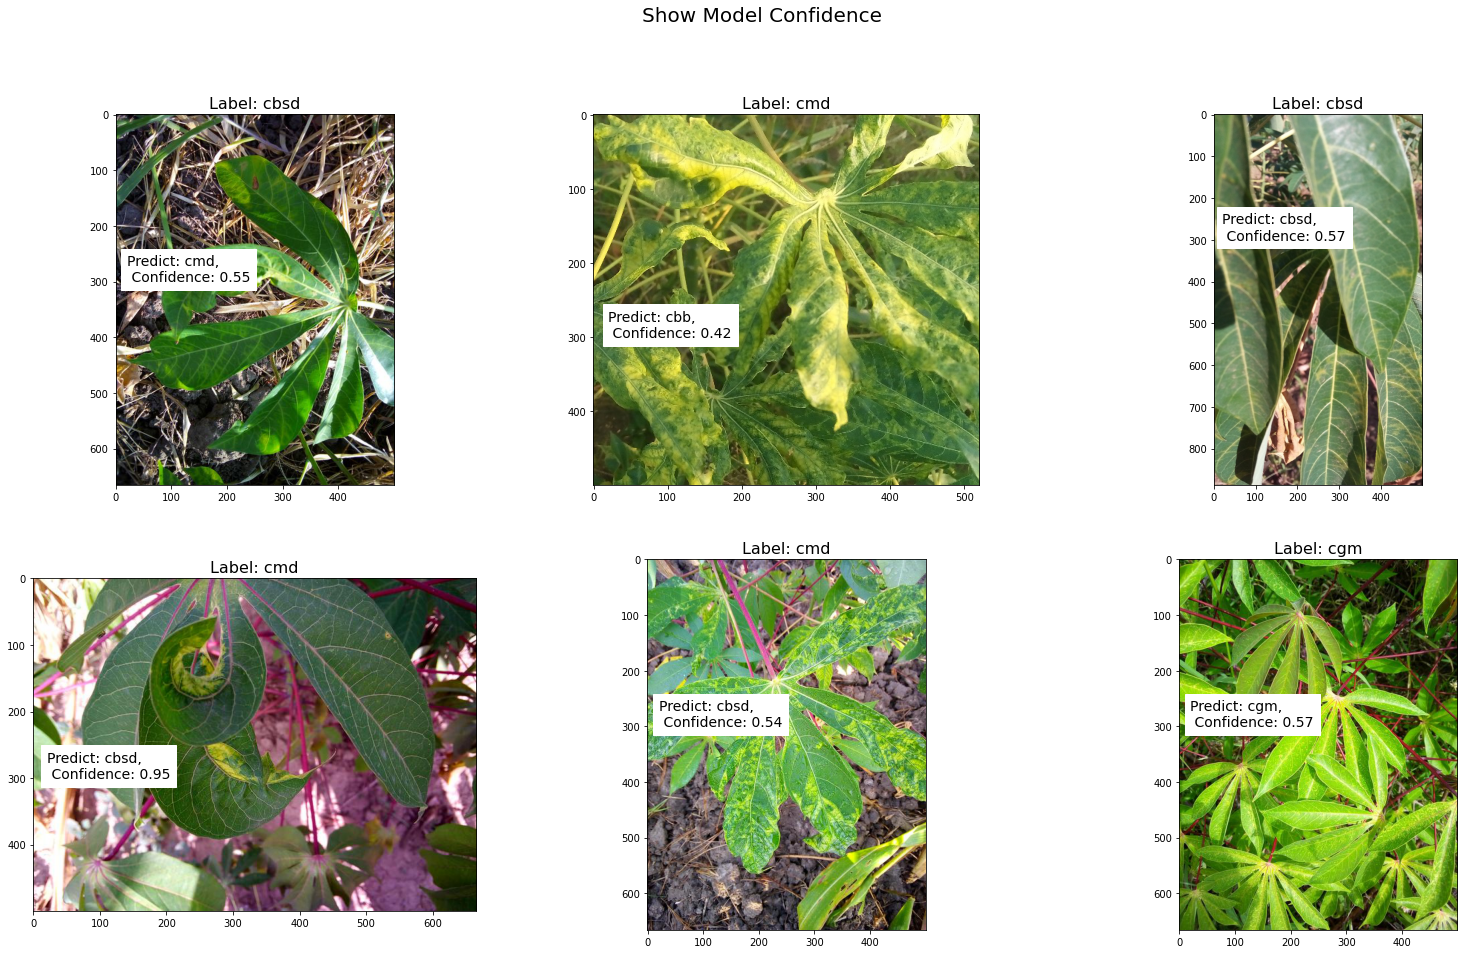

In [84]:
## Отобразим на сколько уверена наша модель в своих предсказаниях
## Можно заметить, что модель часто ошибается
plot_images(my_resnet, valset_1)

Дальше будем использовать модели предобученные на ImageNet

In [ ]:
## Возьмем предобученную сеть resnet50 и переобучем ее последний сверточный блок на нашем датасете
##  Датасет с фотографиями 224х224 с аугментацией
resnet_50 = resnet50(pretrained=True)
for param in resnet_50.parameters():
    param.requires_gard = False
resnet_50.fc = nn.Linear(2048, 5)
for param in resnet_50.fc.parameters():
    param.requires_gard = True
for param in resnet_50.layer4.parameters():
    param.requires_grad = True
for param in resnet_50.layer3.parameters():
    param.requires_gard = False
log_pred = train_net(resnet_50, trainset_2, [valset_1], batch_size=32, num_epoch=10)
                                                                                                      

In [ ]:
## Возьмем предобученную сеть EfficentNet_B4 и переобучем ее  3 последних сверточных блока на нашем датасете
##  Датасет с фотографиями 224х224 с аугментацией
Efficentnet_b4 = EfficientNet.from_pretrained("efficientnet-b4", advprop=False)
for param in Efficentnet_b4.parameters():
    param.requires_grad = False
Efficentnet_b4._fc = nn.Linear(1792, 5)
for param in Efficentnet_b4._blocks[31].parameters():
    param.requires_grad = True
for param in Efficentnet_b4._blocks[30].parameters():
    param.requires_grad = True
for param in Efficentnet_b4._blocks[29].parameters():
    param.requires_grad = True
for param in Efficentnet_b4._fc.parameters():
    param.requiers_grad = True
log_pred = train_net(Efficentnet_b4, trainset_2, [valset_1], batch_size=32, num_epoch=1)
                                                                                                      

##### Максимальный результат, которого удалось добиться на тестовой выборке, используя модели resnet50 и Efficentnet_B4 на данных датасетах не превысил accuracy = 85,5%

In [ ]:
## Модель resnet152 на датасете 224х224, также будем снижать learning_rate во вроемя обучения
resnet_152 = resnet101(pretrained=True)
for param in resnet_152.parameters():
    param.requires_gard = False
resnet_152.fc = nn.Linear(2048, 5)
for param in resnet_152.fc.parameters():
    param.requires_gard = True
for param in resnet_152.layer4.parameters():
    param.requires_grad = True
for param in resnet_152.layer3.parameters():
    param.requires_gard = False
log_pred_1 = train_net(resnet152, trainset_2, [valset_1], batch_size=32, num_epoch=15, learning_rate=5e-5)
log_pred_2 = train_net(resnet152, trainset_2, [valset_1], batch_size=32, num_epoch=1, learning_rate=1e-5)
log_pred_3 = train_net(resnet152, trainset_2, [valset_1], batch_size=32, num_epoch=1, learning_rate=5e-6)
log_pred_4 = train_net(resnet152, trainset_2, [valset_1], batch_size=32, num_epoch=3, learning_rate=1e-6)

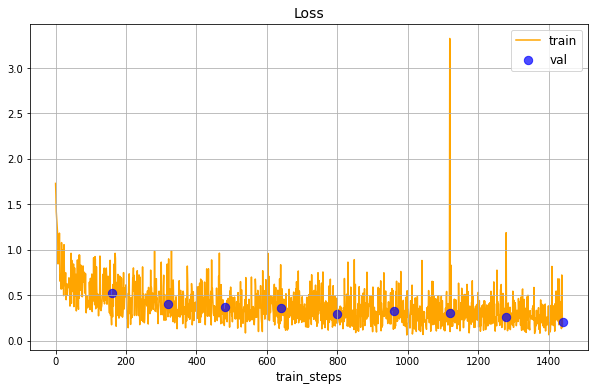

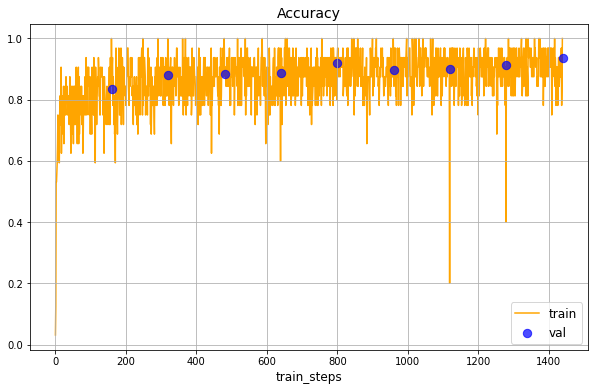

  0%|          | 0/236 [00:00<?, ?it/s]

Iteration: 8
Train_loss: 0.31936523562762886, 0.3162292030174285, 0.28206286337226627
Train_accuracy: 0.898125, 0.8901953125000001, 0.9076171875
Val_loss: 0.30184602708107344, 0.2584293818929129, 0.2037519915546808
Val_accuracy: 0.8993487270574304, 0.9129662522202486, 0.9360568383658969
F1_score: 0.873212764487624, 0.8760875092617967, 0.9064419812711598
Val_variance_loss: 0.02252104938409281, 0.008987718578036544, 0.02677397693730109


100%|██████████| 236/236 [01:09<00:00,  3.38it/s]


In [87]:
## Теперь снова возьмем resnet50, но уже на датасете с фотографиями 448х448 c аугментацией и 
## также будем постепенно понижать learning_rate во врем обучения сети
resnet_50 = resnet50(pretrained=True)
for param in resnet_50.parameters():
    param.requires_gard = False
resnet_50.fc = nn.Linear(2048, 5)
for param in resnet_50.fc.parameters():
    param.requires_gard = True
for param in resnet_50.layer4.parameters():
    param.requires_grad = True
for param in resnet_50.layer3.parameters():
    param.requires_gard = False
    
log_pred_1 = train_net(resnet_50, trainset_3, [valset_3_1, valset_3_2, valset_3_3], batch_size=32,
                       num_epoch=7, learning_rate=1e-4)
log_pred_2 = train_net(resnet_50, trainset_3, [valset_3_1, valset_3_2, valset_3_3], batch_size=32, 
                       num_epoch=1, learning_rate=5e-5)
log_pred_3 = train_net(resnet_50, trainset_3, [valset_3_1, valset_3_2, valset_3_3], batch_size=32,
                       num_epoch=3, learning_rate=1e-5)
log_pred_4 = train_net(resnet_50, trainset_3, [valset_3_1, valset_3_2, valset_3_3], batch_size=32, 
                       num_epoch=2, learning_rate=1e-6)
log_pred_5 = train_net(resnet_50, trainset_3, [valset_3_1, valset_3_2, valset_3_3], batch_size=32,
                       num_epoch=5, learning_rate=1e-7)                                                                                                                

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


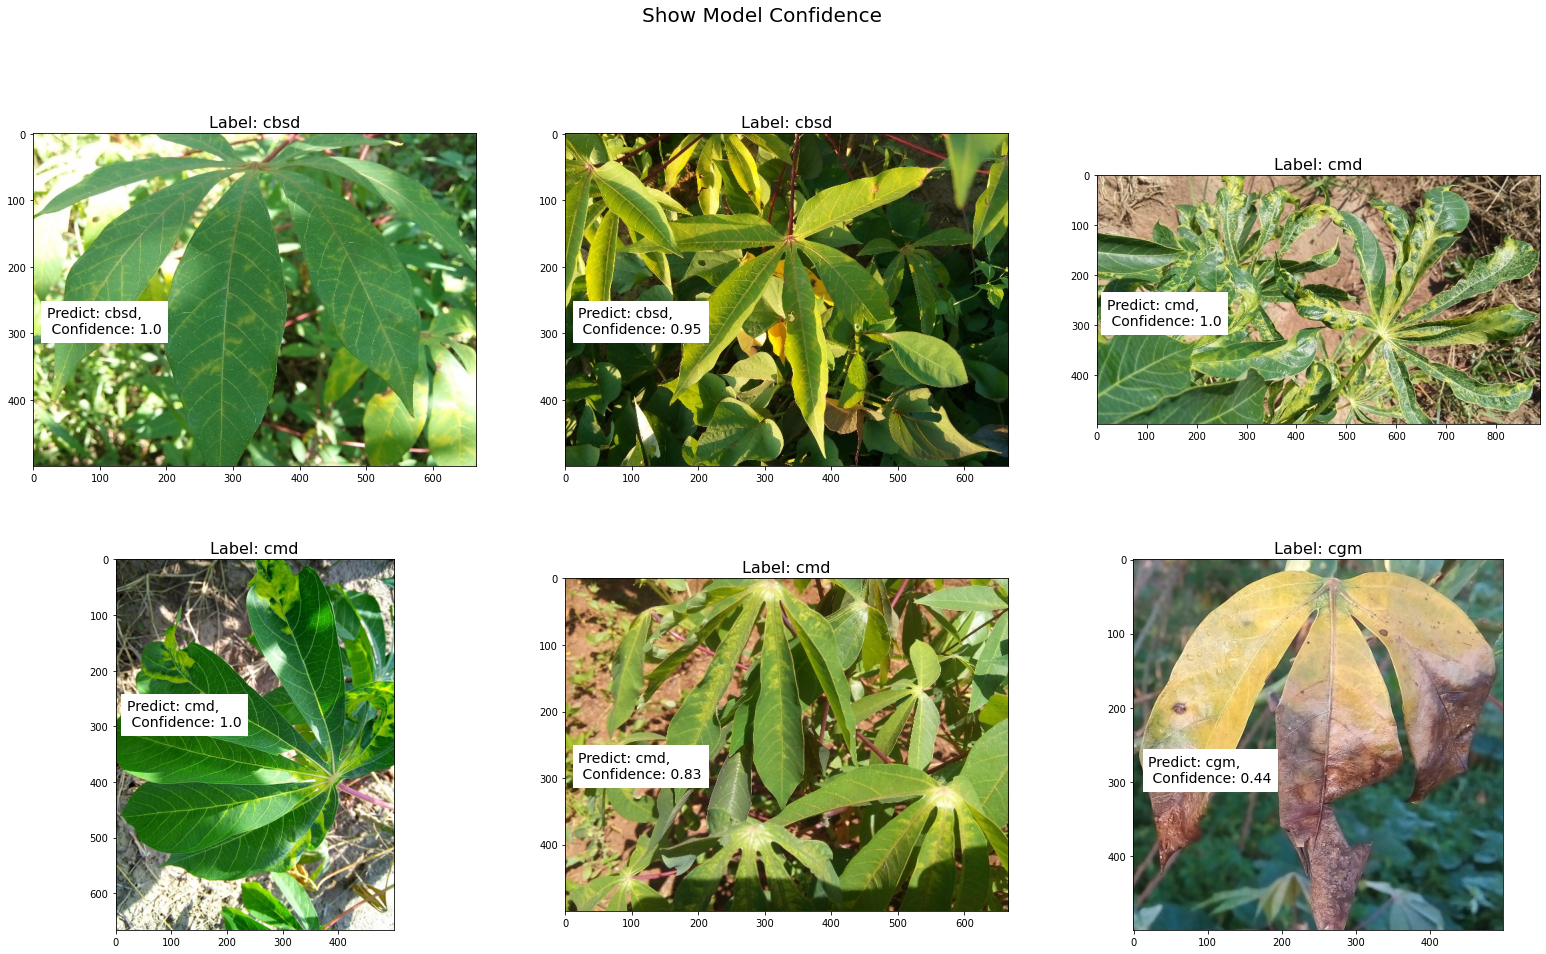

In [88]:
## Снова изобразим уверенность нашей модели в своих предсказаниях
## Теперь видим, что модель намного лучше предсказывает заболевания листьев
plot_images(resnet_50, valset_3_1)

In [ ]:
## Отправим результат на проверку
pred, path = predict(resnet_50, testset_3, batch_size=16)
df_result = pd.read_csv(sample_submission_path)
df_result.Category = pred
df_result.Id = path
df_result.to_csv('submission.csv', index = False)

## 4. Оценка результатов

## Подведем итоги:
1. Для обучения используем модели ResNet предобученные на ImageNet, они лучше отработали для данной задачи
2. Заново обучаем веса для последенего сверточного слоя моделей и полносвязного слоя
3. Снижаем leraning_rate во время обучения моделей
4. Используем аугментацию для обучающих выборок
5. Для настройки моделей используем три валлидационных датасета, с разной аугментацией
6. Сравниваем качество моделей используя средние оценки (log_loss, accuracy, f1_score)
7. Также для сравенения используем оценку разброа для log_loss, чтобы определить модель более устойчивую к новым данным

### Оценим лучшие модели на датасетах с фотографиями 224х224 и 448х448 
#### Лучшие модели на тестовом датасете:

1. #### ResNet152 предобученная на ImageNet: публичная оценка: accuracy = 87.35%, приватная оценка: accuracy = 88.78%
- Фотографии размера 224х224
- Аугментация: transforms.RandomHorizontalFlip(0.5),
                                  transforms.RandomVerticalFlip(0.5),
                                  transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.6),
                                                          transforms.GaussianBlur(7)], 0.5),
                                  transforms.RandomRotation(15),
                                  transforms.RandomErasing(scale=(0.05, 0.05))

2.  #### ResNet50 предобученная на ImageNet: публичная оценка: accuracy = 90.00%, приватная оценка: accuracy = 91.34%
- Фотографии размера 448х448
- Аугментация: transforms.RandomHorizontalFlip(0.5),
                                  transforms.RandomVerticalFlip(0.5),
                                  transforms.RandomApply([transforms.ColorJitter(0.8, 0.5, 0.6),
                                                          transforms.GaussianBlur(3)], 0.5),
                                  transforms.RandomRotation(15),
                                  transforms.RandomErasing(scale=(0.05, 0.05))         